In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
# CONSTANTS
img_height = 128
img_width = 128
channels = 3
factor_size = 8


In [26]:
def split_data(images, annotations, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], annotations[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], annotations[indices[train_samples:]]
    return x_train, y_train, x_valid, y_valid


def get_single_frame(img_path, annotation_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])

    label_img = tf.io.read_file(annotation_path)
    label_img = tf.image.decode_jpeg(label_img, channels=channels)
    label_img = tf.image.convert_image_dtype(label_img, tf.float32)
    label_img = tf.image.resize(label_img, [img_height, img_width])

    return {"image": img, "label": label_img} # it won't work if it's tuple


In [4]:
# data preparation
DATA_DIR = "./data"
images_dir = Path(os.path.join(DATA_DIR, "images"))
annotation_dir = Path(os.path.join(DATA_DIR, "annotations"))

In [5]:
images = sorted(list(map(str, list(images_dir.glob("*")))))
annotations = sorted(list(map(str, list(annotation_dir.glob("*")))))

In [6]:
batch_size = 32
x_train, y_train, x_test, y_test = split_data(np.array(images), np.array(annotations), train_size=0.9)
x_train, y_train, x_valid, y_valid = split_data(x_train, y_train, train_size=0.8)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_dataset = (
    valid_dataset.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

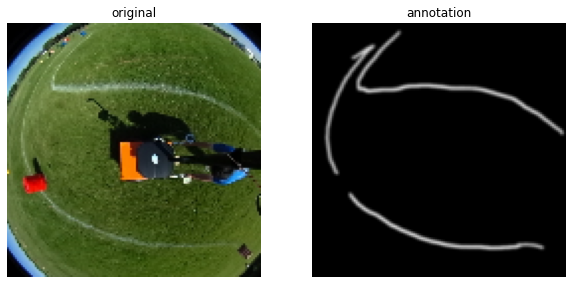

In [7]:
# check some data
def see_train_data(idx=0):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    for batch in train_dataset.take(idx):
        image = batch["image"][0]
        ax[0].imshow((image * 255).numpy().astype("uint8"))
        ax[0].set_title("original")
        ax[0].axis("off")

        annotated_img = batch["label"][0]
        ax[1].imshow((annotated_img * 255).numpy().astype("uint8"))
        ax[1].set_title("annotation")
        ax[1].axis("off")

see_train_data(1)


In [8]:
# preprocessing
# add (rotated, darkened, lightened, flipped, etc) data to the dataset


In [14]:
class AugmentLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name)
        self.augmentation_for_both = keras.models.Sequential([
            layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
            # layers.experimental.preprocessing.RandomRotation(0.05, fill_mode='constant'),
        ])
        self.augmentation_for_input = keras.models.Sequential([
          layers.experimental.preprocessing.RandomContrast(0.15)
        ]) 
        
    @staticmethod
    def merge_img(img1, img2):
        return np.concatenate((img1, img2), axis=-1)

    @staticmethod
    def separate_img(img, divideIdx=-1):
        return img[:, :, :, :divideIdx], img[:, :, :, divideIdx:]
 
    def call(self, input_img, label_img):
        img = self.merge_img(input_img, label_img)
        img = self.augmentation_for_both(img)
        input_img, label_img = self.separate_img(img)
        input_img = self.augmentation_for_input(input_img)
        return input_img, label_img


class MSELayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name)
        self.loss_fn = keras.losses.mean_squared_error

    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        self.add_loss(loss) # necessary
        return y_pred

# train model
def build_model(verbose=0):
    augmentLayer = AugmentLayer(name='preprocess_augment')
    mseLayer = MSELayer()

    input_img = layers.Input(shape=(img_width, img_height, channels), name='input_img')
    label_img = layers.Input(shape=(img_width, img_height, channels), name='label_img')

    augmented_input_img, augmented_label_img = augmentLayer(input_img, label_img)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv_1')(augmented_input_img)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv_1_2')(x)
    x = layers.MaxPooling2D((2, 2), name='MaxPool_1')(x)
    x = layers.BatchNormalization(name='BatchNorm_1')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv_2')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv_2_2')(x)
    x = layers.MaxPooling2D((2, 2), name='MaxPool_2')(x)
    x = layers.BatchNormalization(name='BatchNorm_2')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', name='Conv_3')(x)
    x = layers.MaxPooling2D((2, 2), name='MaxPool_3')(x)
    x = layers.BatchNormalization(name='BatchNorm_3')(x)

    x = layers.Conv2DTranspose(64, 3, padding='same', name='ConvT_1')(x)
    x = layers.BatchNormalization(name='BatchNormT_1')(x)
    x = layers.UpSampling2D(2, name='UpSampleT_1')(x)

    x = layers.Conv2DTranspose(64, 3, padding='same', name='ConvT_2')(x)
    x = layers.BatchNormalization(name='BatchNormT_2')(x)
    x = layers.UpSampling2D(2, name='UpSampleT_2')(x)

    x = layers.Conv2DTranspose(32, 3, padding='same', name='ConvT_3')(x)
    x = layers.BatchNormalization(name='BatchNormT_3')(x)
    x = layers.UpSampling2D(2, name='UpSampleT_3')(x)

    output_img = layers.Conv2D(1, (1, 1), padding='same', name='Conv_Last')(x)
    loss = mseLayer(augmented_label_img, output_img)

    model = keras.models.Model(inputs=[input_img, label_img], outputs=loss)
    model.compile(optimizer='adam')
    if verbose:
        model.summary()
    return model

In [21]:
model = build_model(verbose=1)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
label_img (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
augment_layer_4 (AugmentLayer)  ((None, 128, 128, 3) 0           input_img[0][0]                  
                                                                 label_img[0][0]                  
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 128, 128, 32) 896         augment_layer_4[0][0] 

In [22]:
# train
epochs = 100
r = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs)

Epoch 1/100
4/4 [==============================] - 3s 705ms/step - loss: 0.2871 - val_loss: 0.2597
Epoch 2/100
4/4 [==============================] - 3s 665ms/step - loss: 0.2294 - val_loss: 0.2669
Epoch 3/100
4/4 [==============================] - 3s 664ms/step - loss: 0.1773 - val_loss: 0.1411
Epoch 4/100
4/4 [=============================

In [ ]:
# check loss values
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# prediction model
i = layers.Input(shape=(img_width, img_height, channels), name='new_input')
x = i
start = model.get_layer(name='Conv_1')
end  = model.get_layer(name='Conv_Last')

model_layers = model.layers[:]
graph_started = False
for layer in model_layers:
    if layer is start:
        graph_started = True

    if graph_started:
        x = layer(x)
        if layer is end:
            break

pred_model = keras.models.Model(i, x)
pred_model.summary()

In [ ]:
# evalution
def get_IOU(threshold=0.75):
    y_hat = pred_model.predict(x_test) > threshold
    y_test = y_test > threshold

    # code it up
    return 0




In [ ]:
# visualize result
def check_result():
    _, ax = plt.subplots(4, 3, figsize=(10, 10))
    for batch in valid_dataset.take(1):
        images = batch["image"]
        preds = pred_model.predict(images)
        labels = batch["label"]
        for i in range(4):
            ax[i, 0].imshow((images[i] * 255).numpy().astype('uint8'))
            ax[i, 0].set_title(f"original: {i}")
            ax[i, 0].axis("off")

            ax[i, 1].imshow(preds[i], cmap='gray')
            ax[i, 1].set_title(f"predict: {i}")
            ax[i, 1].axis("off")

            ax[i, 2].imshow(labels[i], cmap='gray')
            ax[i, 2].set_title(f"predict: {i}")
            ax[i, 2].axis("off")

check_result()

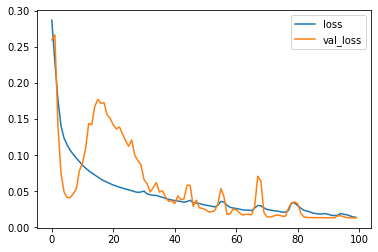

In [24]:
# prediction model
i = layers.Input(shape=(img_width, img_height, channels), name='new_input')
x = i
start = model.get_layer(name='Conv_1')
end  = model.get_layer(name='Conv_Last')

model_layers = model.layers[:]
graph_started = False
for layer in model_layers:
    if layer is start:
        graph_started = True

    if graph_started:
        x = layer(x)
        if layer is end:
            break

pred_model = keras.models.Model(i, x)
pred_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 64, 64, 32)        0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 64, 64, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 64, 64, 64)       

In [ ]:
# evalution
def get_IOU(threshold=0.75):
    y_hat = pred_model.predict(x_test) > threshold
    y_test = y_test > threshold

    # code it up
    return 0




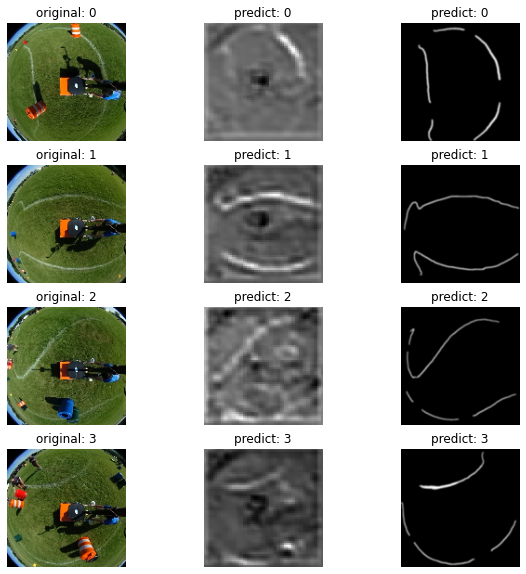

In [25]:
# visualize result
def check_result():
    _, ax = plt.subplots(4, 3, figsize=(10, 10))
    for batch in valid_dataset.take(1):
        images = batch["image"]
        preds = pred_model.predict(images)
        labels = batch["label"]
        for i in range(4):
            ax[i, 0].imshow((images[i] * 255).numpy().astype('uint8'))
            ax[i, 0].set_title(f"original: {i}")
            ax[i, 0].axis("off")

            ax[i, 1].imshow(preds[i], cmap='gray')
            ax[i, 1].set_title(f"predict: {i}")
            ax[i, 1].axis("off")

            ax[i, 2].imshow(labels[i], cmap='gray')
            ax[i, 2].set_title(f"predict: {i}")
            ax[i, 2].axis("off")

check_result()